In [ ]:
dirs = ["[5-40]-value_comp_incl50all.pkl", "[5-40]-value_comp.pkl"]
vars = ["rt"]#, "dspace", "splitrt", "sspace", "tspace"]

for v in vars:
    df = pd.DataFrame()
    for d in dirs:
        df = pd.concat([df, pd.read_pickle("/usr/app/output/scen/%s" % (d))])
        if d == '[5-40]-value_comp_incl50all.pkl':
            df["Algorithm"] = "ADP(50,all)"
        if d == '[5-40]-value_comp.pkl':
            df.loc[df.Algorithm == "adp", "Algorithm"] = "ADP(1000,all)"

    
    df.to_pickle("/usr/app/output/scen/[5-40]-value_comp_final.pkl")



In [45]:
%load_ext autoreload
%autoreload 2

import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
import numpy as np
from mpl_axes_aligner import align

from src.modules import plotter as p
from src.modules.analysis import analyseValue, createScenarios, runScen
from src.modules.probabilities import Probabilities
from src.modules import plotter as plttr

plt.style.use(['seaborn-paper','science','no-latex', 'std-colors'])
matplotlib.rc("font", family="Times New Roman")    
plts = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

lw = 2
ms = 8

In [47]:
# Config
param = {"T": 5, "trip_max": 40, "iterations_adp": 1000, "samples_adp": None}
states = '[%s-%s]-statespace' % (param["T"], param["trip_max"])
algos = ['mo', "adp"]
iniState = '0,40.0,0.0,0.0,0.044,0.039'
prob = Probabilities()
runs = [("Value Iteration - 25kWh Battery", "vi/20210722_final_25kWh"), 
        ("Value Iteration - 50kWh Battery", "vi/20210722_final_50kWh"), 
        ("Myopic Optimization", "mo/20210722_final"), 
        ("Approx. Dynamic Programming (1000,all)", "adp/20210730_final_for_real")]

In [ ]:
# Load decisions
dict_dec = {}

lookup = ["[vi]-[%s-%s]" % (param["T"], param["trip_max"]), 
             "[mo]-[%s-%s]" % (param["T"], param["trip_max"]), 
             "[adp-(%s %s)]-[%s-%s]" % (param["iterations_adp"], param["samples_adp"], param["T"], param["trip_max"])]

dict_dec["mo"] = None # Not relevant for MO
dict_dec["adp"] = pd.read_pickle("/usr/app/output/xlsx/%s/%s-lookup.pkl" % (runs[3][1],lookup[2])).set_index('s_key', drop=False)


# Load states

app = App("vi")
T = 5
trip_max = 40

df_states = app.constructStates(T, trip_max, None).reset_index()
df_states["t"] = df_states["s_obj"].apply(lambda s: s.get_t())
df_states = df_states.set_index("t",drop=True)
analyseValue(dict_dec, iniState, prob, df_states[["s_key","s_obj"]], param)

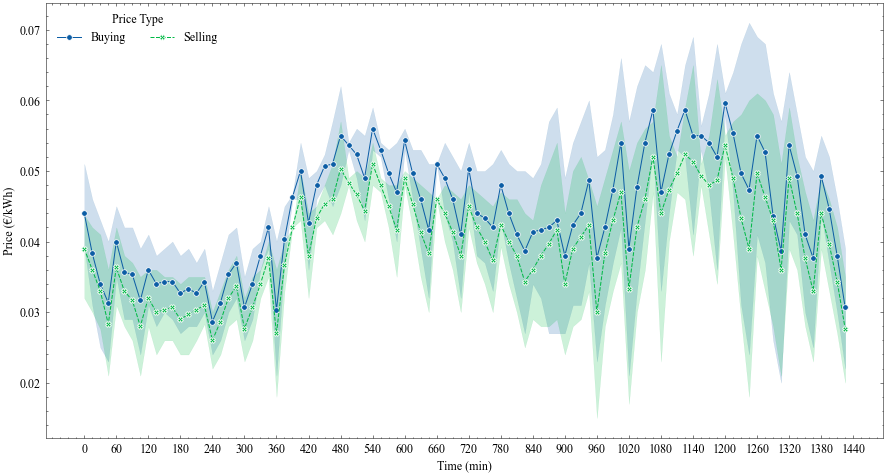

In [4]:
# [GEN] => see data analysis
## 1. Electricity prices for buy and sell with error bars at time
d_prc_b = pd.read_pickle("/usr/app/data/probabilities/d_prc_b.pkl") 
d_prc_s = pd.read_pickle("/usr/app/data/probabilities/d_prc_s.pkl") 
d_prc_b["type"] = "b"
d_prc_s["type"] = "s"
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=pd.concat([d_prc_b, d_prc_s]), x="t", y="prc", hue="type",style="type", markers=True,  legend = False)
plttr.formatPlot(g, "Time (min)" , "Price (€/kWh)","Buying and Selling Prices with Error Bounds" , np.arange(0, 1441, 60), None, "Price Type", ['Buying', 'Selling'], "upper left")
plts = [("prob_prc_t", plt.gcf())]


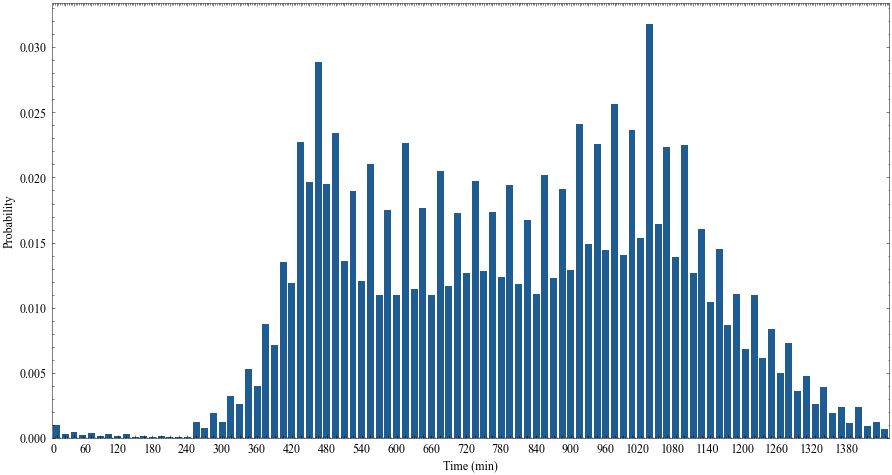

In [5]:
## 2. Probability to start trip at time
d_trpstrt = pd.read_pickle("/usr/app/data/probabilities/trpstrt.pkl") 
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.barplot(ax=ax, data=d_trpstrt, x="t", y="p(t)", color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

plttr.formatPlot(g, "Time (min)" ,"Probability","Tripstart Probability", dense=4)

plts += [("prob_trpstrt", plt.gcf())]


In [6]:
## 3. Probability for trip length according to length and time
d_trpln = pd.read_pickle("/usr/app/data/probabilities/trplen.pkl") 
d_trpln = pd.melt(d_trpln.iloc[:,:-1].copy(), id_vars=['t'], var_name = "Length", value_name = "d(t)")
d_trpln["d(t)"] = d_trpln["d(t)"]*100
d_trpln["d(t)"] = d_trpln["d(t)"].astype("int32")
d_trpln_pivot = d_trpln.pivot("t", "Length", "d(t)")


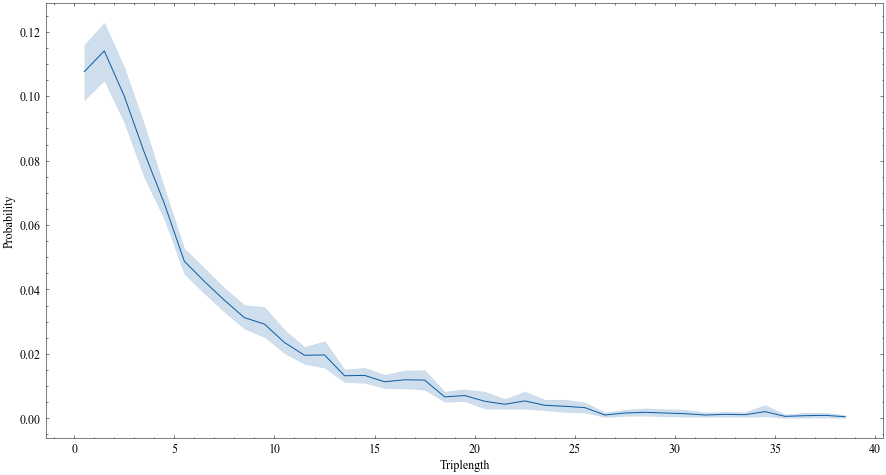

In [7]:
f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(x=d_trpln["Length"], y=d_trpln["d(t)"]/100, markers=True, legend = False)
plttr.formatPlot(g, "Triplength", "Probability", "Avg. Probability of Triplengths with Error Bounds")
plts += [("prob_trpln_agg", plt.gcf())]

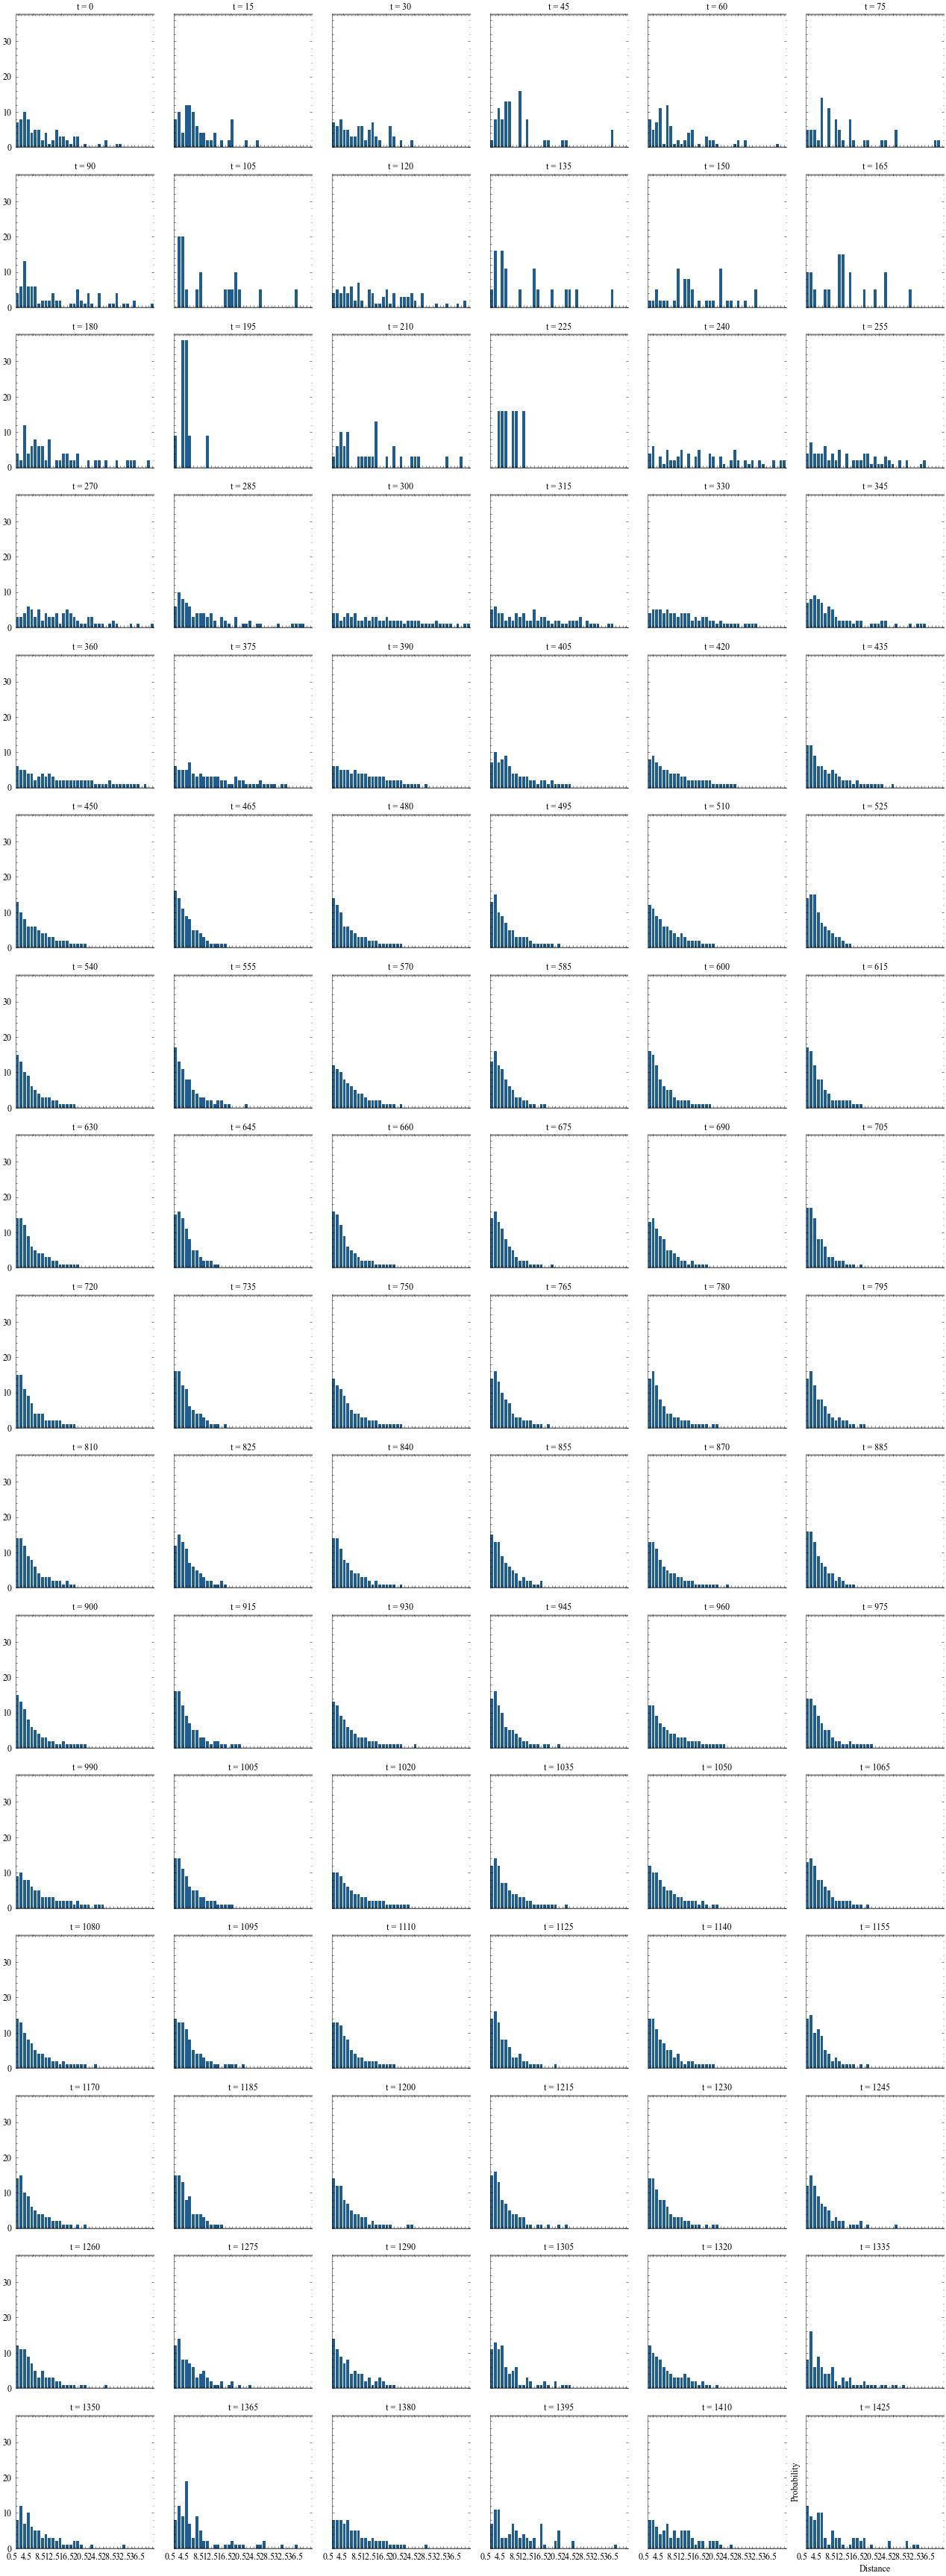

In [8]:
g = sns.FacetGrid(d_trpln, col="t", col_wrap = 6)
g.map_dataframe(sns.barplot, x="Length", y="d(t)")
plttr.formatPlot(g, "Distance", "Probability", "Probability of Triplengths per Time Index", dense=4)

plts += [("prob_trpln_indiv", plt.gcf())]

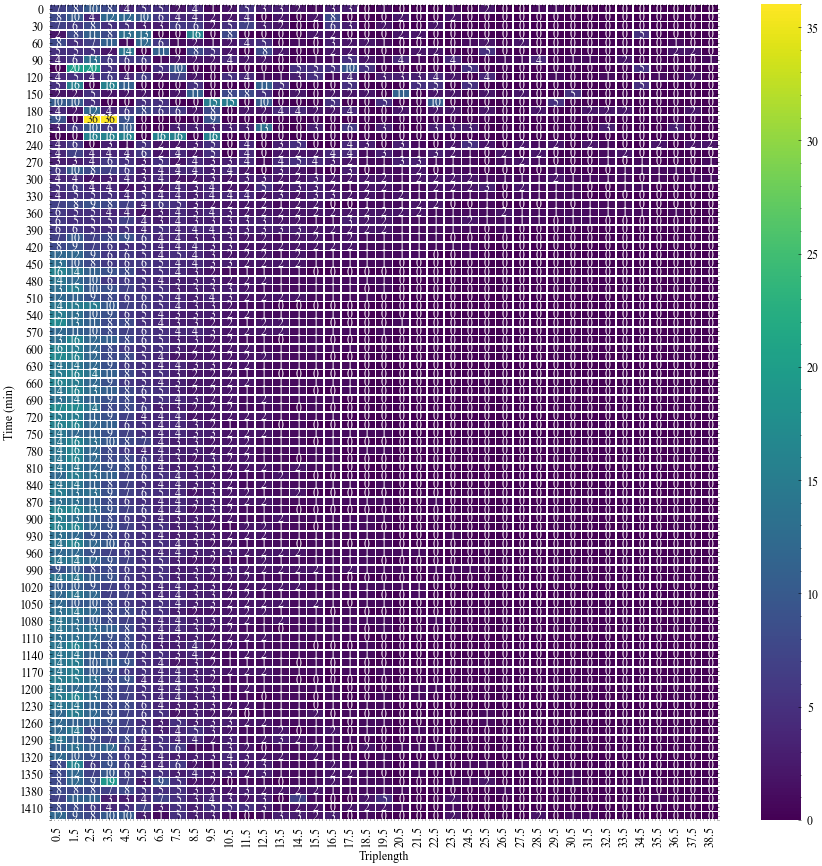

In [9]:
f, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(d_trpln_pivot, annot=True, fmt="d", linewidths=.5, ax=ax, cmap = sns.color_palette("viridis", as_cmap=True))
plttr.formatPlot(g, "Triplength", "Time (min)", "Probability of Triplengths")
plts += [("prob_trpln_heat", plt.gcf())]

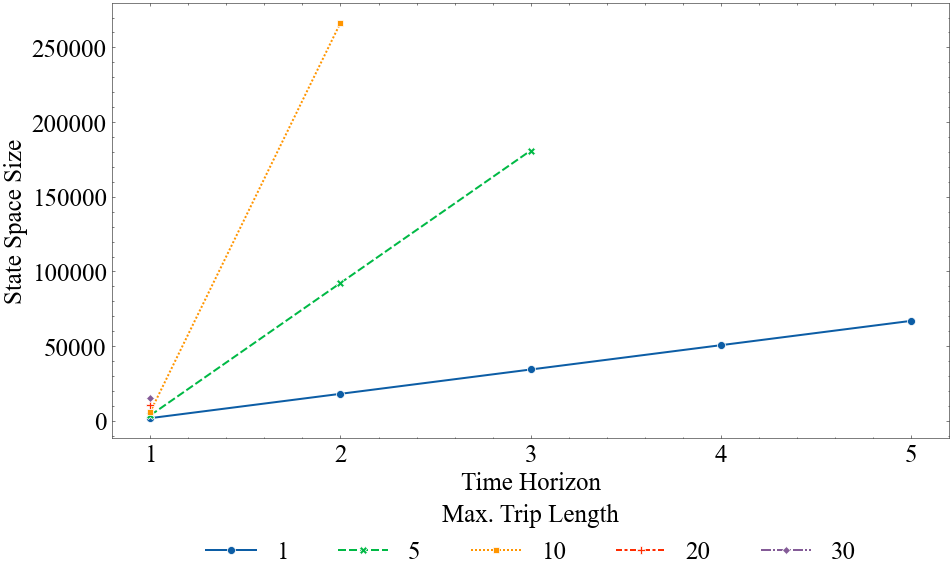

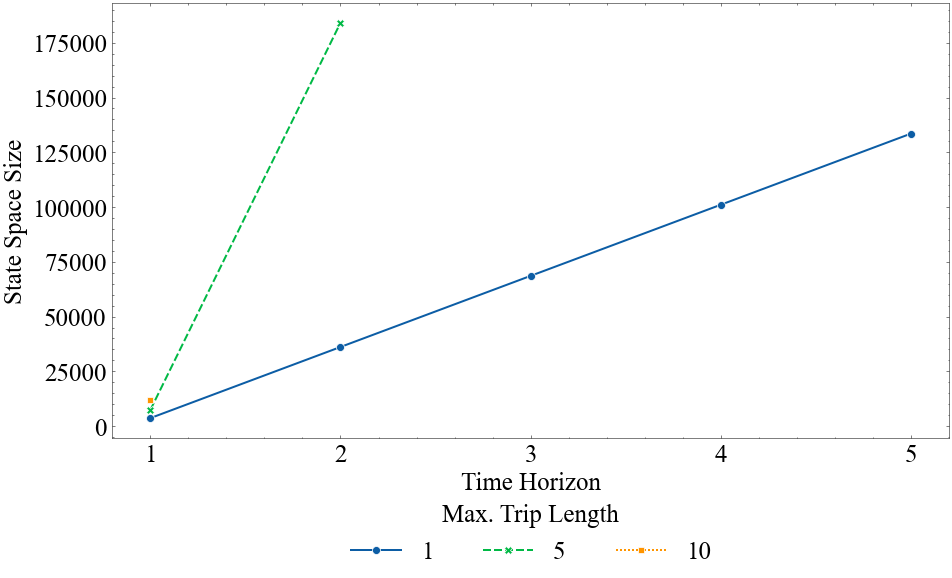

In [68]:
# 2.[VI] State comparison in dependence of parameters
stateSpace = pd.read_pickle("/usr/app/output/xlsx/%s/sspace.pkl" % runs[0][1]).astype({"trip_max":str,"amount": int, "T": int})
f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=stateSpace, x="T", y="amount", hue = "trip_max", style="trip_max", markers=True, legend = False, linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon", "State Space Size", "Value Iteration - State Space Size for Different Parameters",np.arange(1, stateSpace["T"].max()+1), None, "Max. Trip Length", [str(x) for x in stateSpace.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_state_space_25", plt.gcf())]

stateSpace = pd.read_pickle("/usr/app/output/xlsx/%s/sspace.pkl" % runs[1][1]).astype({"trip_max":str,"amount": int, "T": int})
f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=stateSpace, x="T", y="amount", hue = "trip_max", style="trip_max", markers=True, legend = False, linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon", "State Space Size", "Value Iteration - State Space Size for Different Parameters",np.arange(1, stateSpace["T"].max()+1), None, "Max. Trip Length", [str(x) for x in stateSpace.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_state_space_50", plt.gcf())]

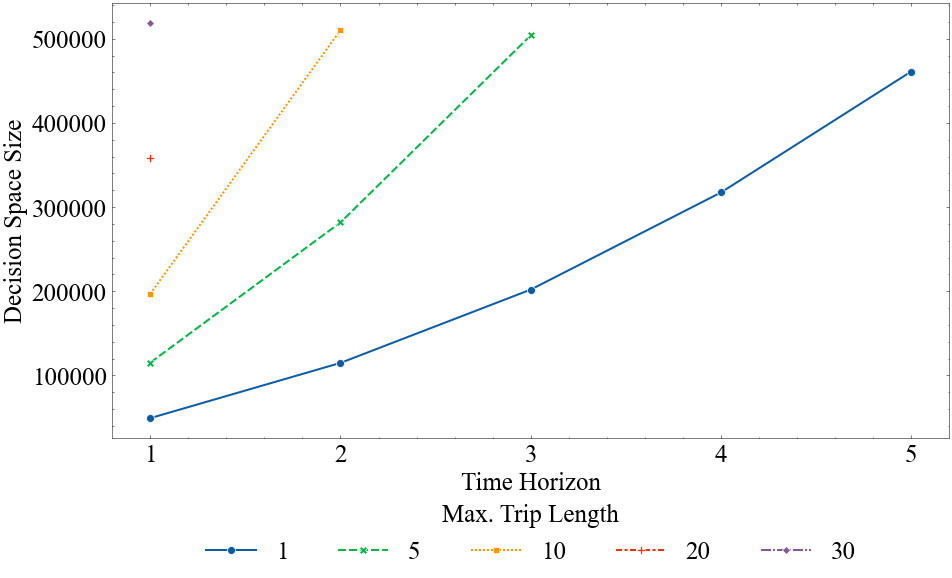

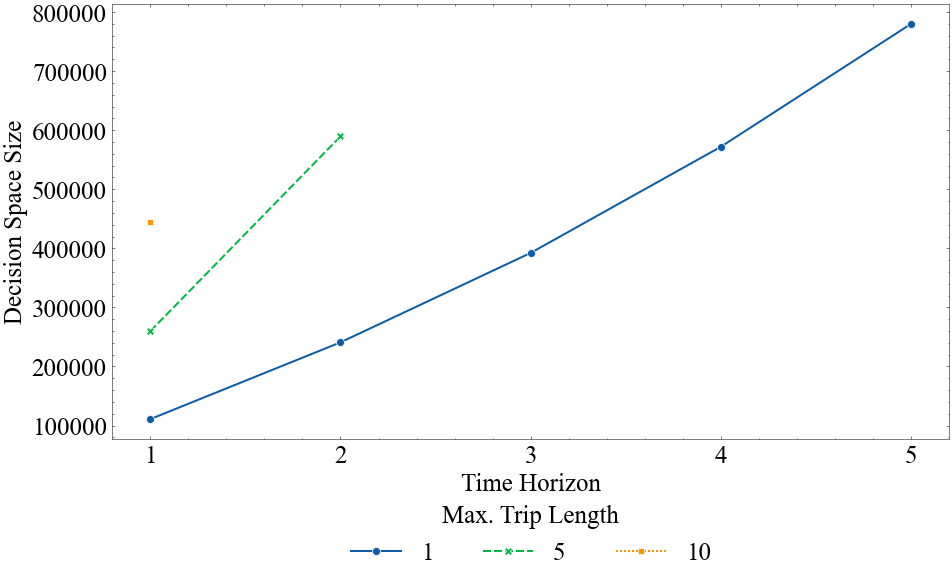

In [69]:
# 2.[VI] Decision comparison in dependence of parameters
decisionSpace = pd.read_pickle("/usr/app/output/xlsx/%s/dspace.pkl" % runs[0][1]).astype({"trip_max":str,"amount": int, "T": int})

f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=decisionSpace, x="T", y="amount", hue = "trip_max", style="trip_max", markers=True, legend = False, linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon", "Decision Space Size", "Value Iteration - Decision Space Size for Different Parameters",np.arange(1, decisionSpace["T"].max()+1), None, "Max. Trip Length", [str(x) for x in decisionSpace.trip_max.unique()], "upper center", bbox=(0.5, -0.1))
plts += [("vi_decision_space_25", plt.gcf())]

# 2.[VI] Decision comparison in dependence of parameters
decisionSpace = pd.read_pickle("/usr/app/output/xlsx/%s/dspace.pkl" % runs[1][1]).astype({"trip_max":str,"amount": int, "T": int})

f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=decisionSpace, x="T", y="amount", hue = "trip_max", style="trip_max", markers=True, legend = False, linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon", "Decision Space Size", "Value Iteration - Decision Space Size for Different Parameters",np.arange(1, decisionSpace["T"].max()+1), None, "Max. Trip Length", [str(x) for x in decisionSpace.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_decision_space_50", plt.gcf())]

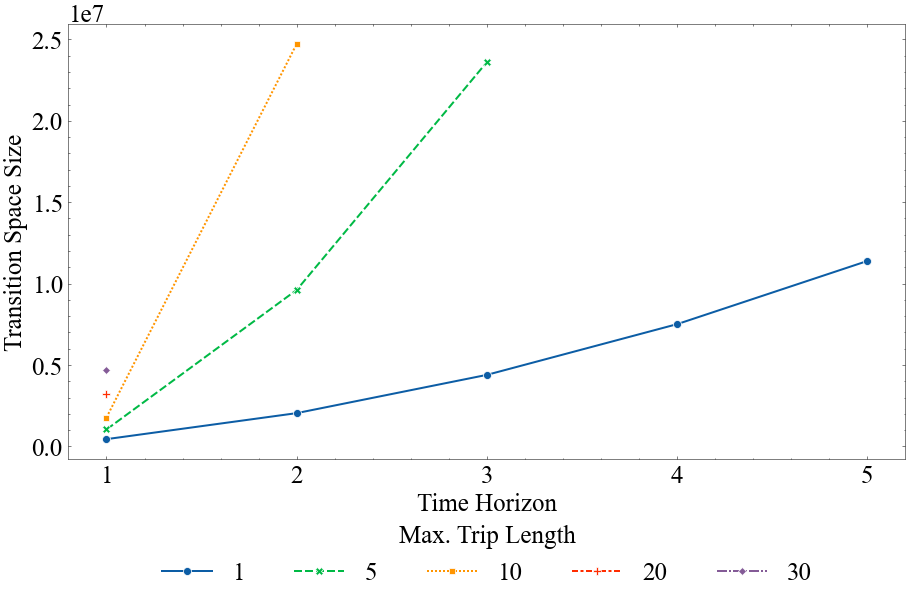

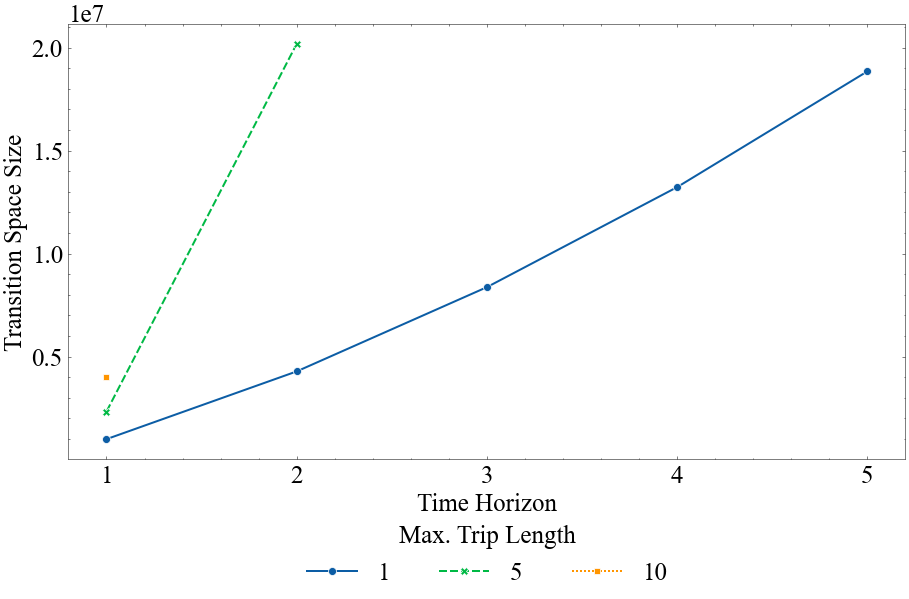

In [70]:
# 2.[VI] Total comparison in dependence of parameters
transitionSpace = pd.read_pickle("/usr/app/output/xlsx/%s/tspace.pkl" % runs[0][1]).astype({"trip_max":str,"amount": int, "T": int})

f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=transitionSpace, x="T", y="amount", hue = "trip_max", style="trip_max", markers=True, legend = False, linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon", "Transition Space Size", "Value Iteration - Transition Space Size for Different Parameters",np.arange(1, transitionSpace["T"].max()+1), None, "Max. Trip Length", [str(x) for x in transitionSpace.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_transition_space_25", plt.gcf())]

transitionSpace = pd.read_pickle("/usr/app/output/xlsx/%s/tspace.pkl" % runs[1][1]).astype({"trip_max":str,"amount": int, "T": int})

f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=transitionSpace, x="T", y="amount", hue = "trip_max", style="trip_max", markers=True, legend = False, linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon", "Transition Space Size", "Value Iteration - Transition Space Size for Different Parameters",np.arange(1, transitionSpace["T"].max()+1), None, "Max. Trip Length", [str(x) for x in transitionSpace.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_transition_space_50", plt.gcf())]

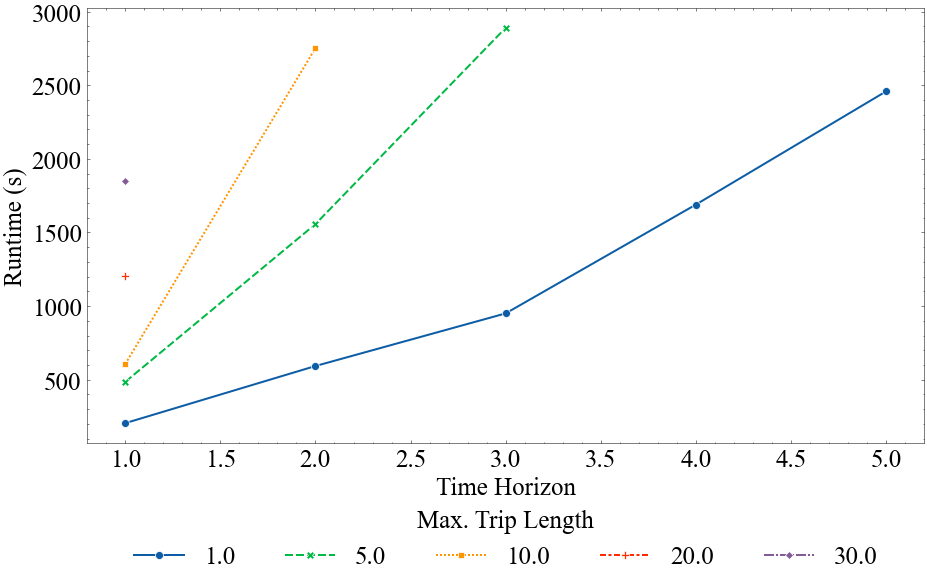

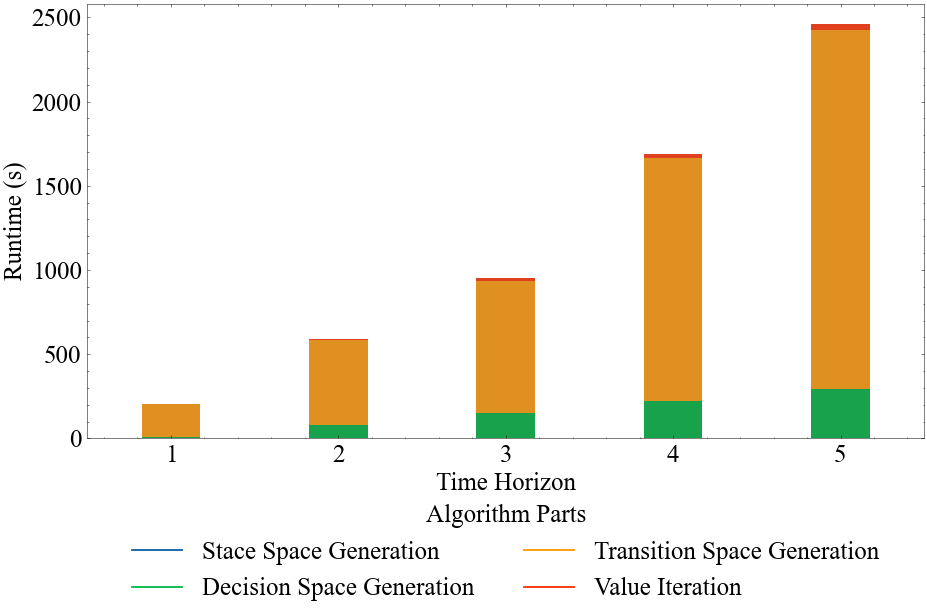

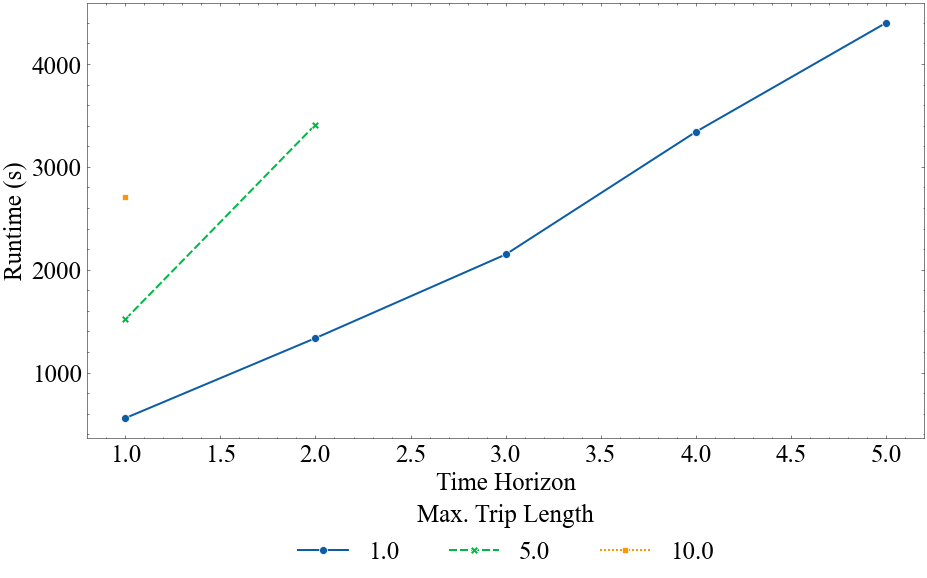

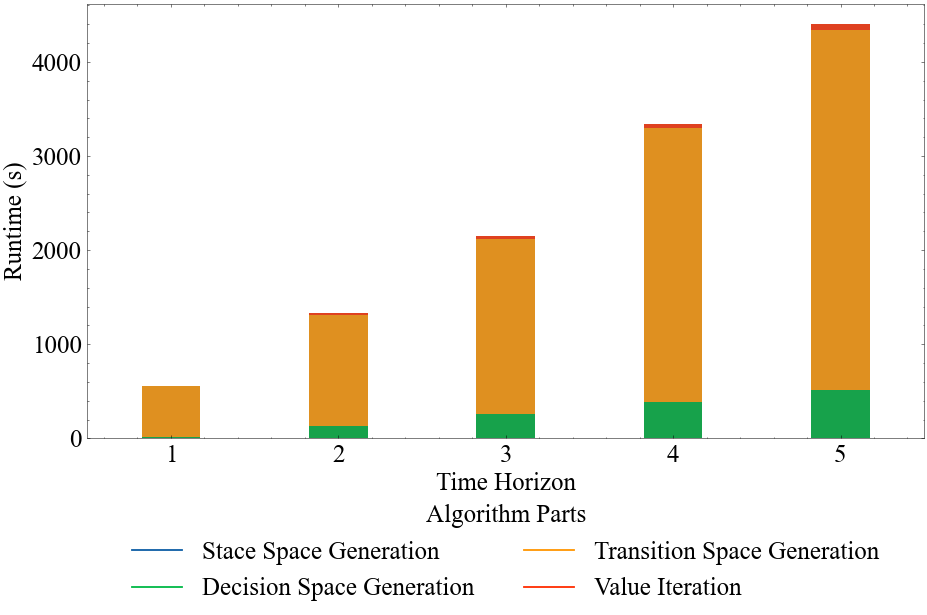

In [72]:
# 3. [VI] Runtime comparison VI
runtime = pd.read_pickle("/usr/app/output/xlsx/%s/rt.pkl" % runs[0][1]).astype({"trip_max":str,"time": float, "T": int})
splitRuntime = pd.read_pickle("/usr/app/output/xlsx/%s/splitrt.pkl" % runs[0][1]).astype({"trip_max":str, "T": int, "t_state": float, "d_state": float, "tr_state": float, "vi": float})

# Runtime
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax = ax, x = 'T', y = 'time', hue = "trip_max", style="trip_max", markers=True, data = runtime, linewidth=lw, markersize=ms)
plttr.change_width(ax, .35)
plttr.formatPlot(g, "Time Horizon", "Runtime (s)", "Value Iteration - Runtime for Different Parameters",None, None, "Max. Trip Length", [str(x) for x in runtime.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_rt_25", plt.gcf())]

# Split runtime
######## IMPORTANT Need to select specific trip max
max_trp_ln = '1.0'
splitRuntime = splitRuntime.loc[(splitRuntime.trip_max == max_trp_ln), ["T","t_state", "d_state", "tr_state", "vi"]]

fig, ax = plt.subplots(figsize=(15, 8))

s1 = sns.barplot(x = 'T', y = 'vi', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
s2 = sns.barplot(x = 'T', y = 'tr_state', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
s3 = sns.barplot(x = 'T', y = 'd_state', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
g = sns.barplot(x = 'T', y = 't_state', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plttr.change_width(ax, .35)
plttr.formatPlot(g, "Time Horizon", "Runtime (s)", "Value Iteration - Detailed Runtime for Different Time Horizons (Max. Trip Length = %s)" % max_trp_ln,None, None, "Algorithm Parts", ["Stace Space Generation", "Decision Space Generation", "Transition Space Generation", "Value Iteration"], "upper center",bbox=(0.5, -0.1),ncol=2)
plts += [("vi_splitrt_25", plt.gcf())]

runtime = pd.read_pickle("/usr/app/output/xlsx/%s/rt.pkl" % runs[1][1]).astype({"trip_max":str,"time": float, "T": int})
splitRuntime = pd.read_pickle("/usr/app/output/xlsx/%s/splitrt.pkl" % runs[1][1]).astype({"trip_max":str, "T": int, "t_state": float, "d_state": float, "tr_state": float, "vi": float})

# Runtime
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax = ax, x = 'T', y = 'time', hue = "trip_max", style="trip_max", markers=True, data = runtime, linewidth=lw, markersize=ms)
plttr.change_width(ax, .35)
plttr.formatPlot(g, "Time Horizon", "Runtime (s)", "Value Iteration - Runtime for Different Parameters",None, None, "Max. Trip Length", [str(x) for x in runtime.trip_max.unique()], "upper center",bbox=(0.5, -0.1))
plts += [("vi_rt_50", plt.gcf())]

# Split runtime
## Need to select specific trip max
max_trp_ln = '1.0'
splitRuntime = splitRuntime.loc[(splitRuntime.trip_max == max_trp_ln), ["T","t_state", "d_state", "tr_state", "vi"]]

fig, ax = plt.subplots(figsize=(15, 8))

s1 = sns.barplot(x = 'T', y = 'vi', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
s2 = sns.barplot(x = 'T', y = 'tr_state', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
s3 = sns.barplot(x = 'T', y = 'd_state', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
g = sns.barplot(x = 'T', y = 't_state', data = splitRuntime, color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plttr.change_width(ax, .35)
plttr.formatPlot(g, "Time Horizon", "Runtime (s)", "Value Iteration - Detailed Runtime for Different Time Horizons (Max. Trip Length = %s)" % max_trp_ln,None, None, "Algorithm Parts", ["Stace Space Generation", "Decision Space Generation", "Transition Space Generation", "Value Iteration"], "upper center",bbox=(0.5, -0.1),ncol=2)
plts += [("vi_splitrt_50", plt.gcf())]



In [60]:
### FROM HERE ON SMALLER AS ON FULL WIDTH
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

lw = 2
ms = 8

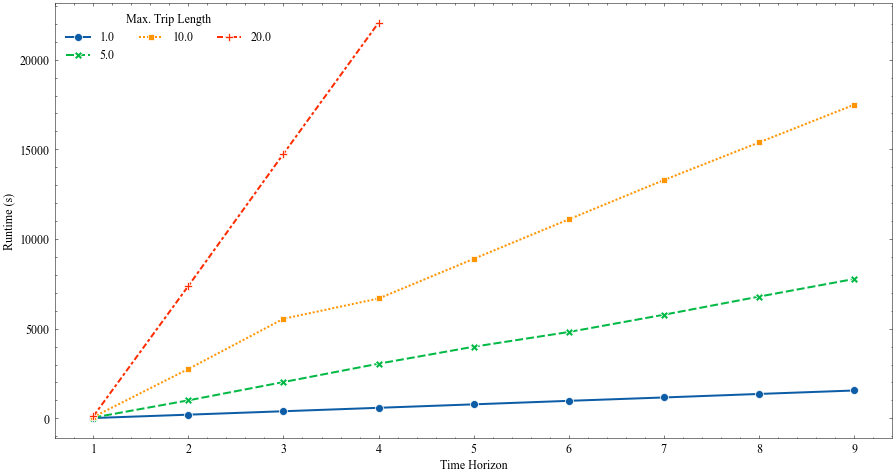

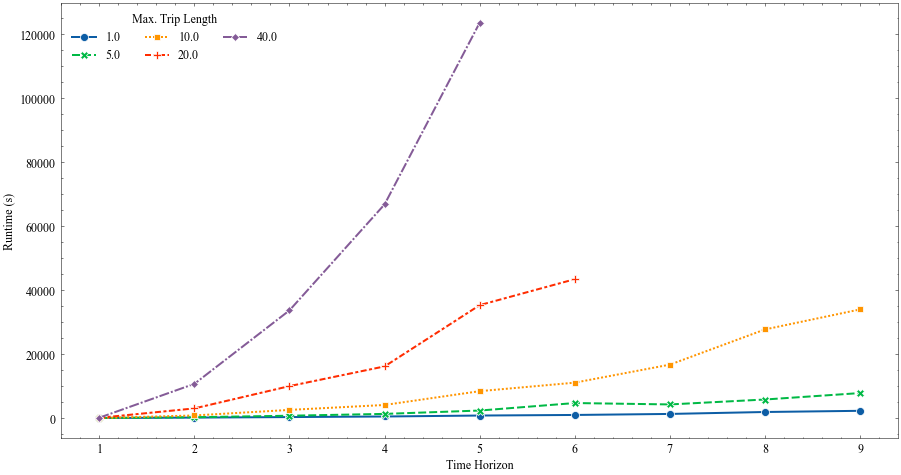

In [66]:
# 3. [~VI] Runtime comparison MO/ADP
runtime = pd.read_pickle("/usr/app/output/xlsx/%s/rt.pkl" % runs[2][1]).astype({"trip_max":str,"time": float, "T": int})

# Runtime
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax = ax, x = 'T', y = 'time', hue = "trip_max", style="trip_max", markers=True, data = runtime, linewidth=lw, markersize=ms)
plttr.change_width(ax, .35)
plttr.formatPlot(g, "Time Horizon", "Runtime (s)", "Myopic Optimization - Runtime for Different Parameters",None, None, "Max. Trip Length", [str(x) for x in runtime.trip_max.unique()], "upper left",ncol=3)
plts += [("mo_rt", plt.gcf())]
          
runtime = pd.read_pickle("/usr/app/output/xlsx/%s/rt.pkl" % runs[3][1]).astype({"trip_max":float,"time": float, "T": int}).sort_values(["T", "trip_max"]).astype({"trip_max":str,"time": float, "T": int})

# Runtime
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax = ax, x = 'T', y = 'time', hue = "trip_max", style="trip_max", markers=True, data = runtime, linewidth=lw, markersize=ms)
plttr.change_width(ax, .35)
plttr.formatPlot(g, "Time Horizon", "Runtime (s)", "Approximate Dynamic Programming - Runtime for Different Parameters",None, None, "Max. Trip Length", [str(x) for x in runtime.trip_max.unique()], "upper left",ncol=3)
plts += [("adp_rt", plt.gcf())]

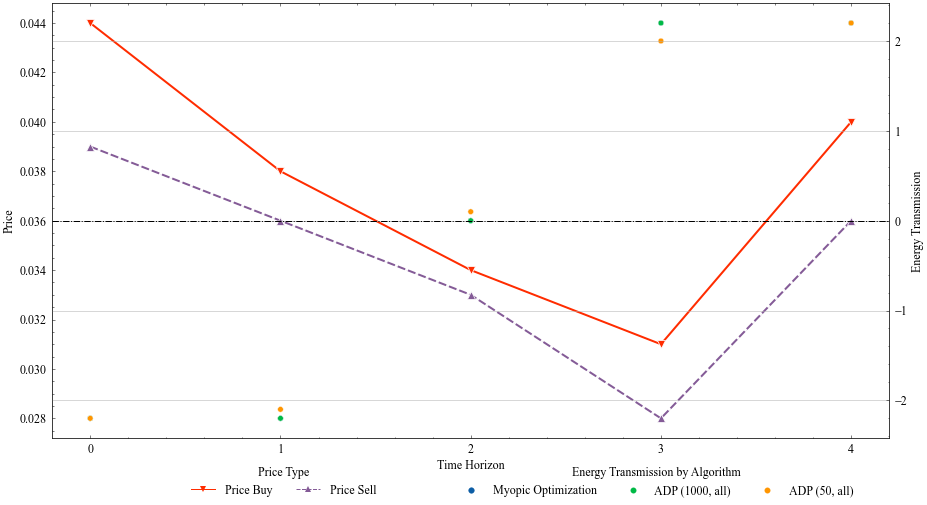

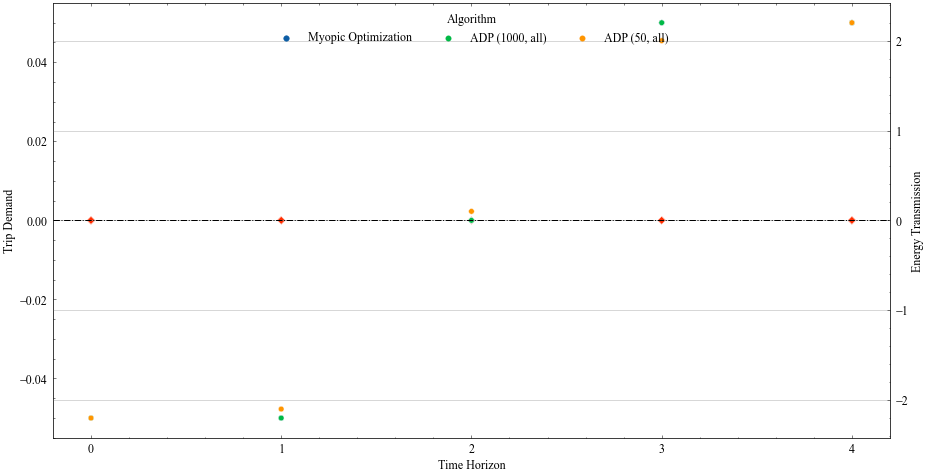

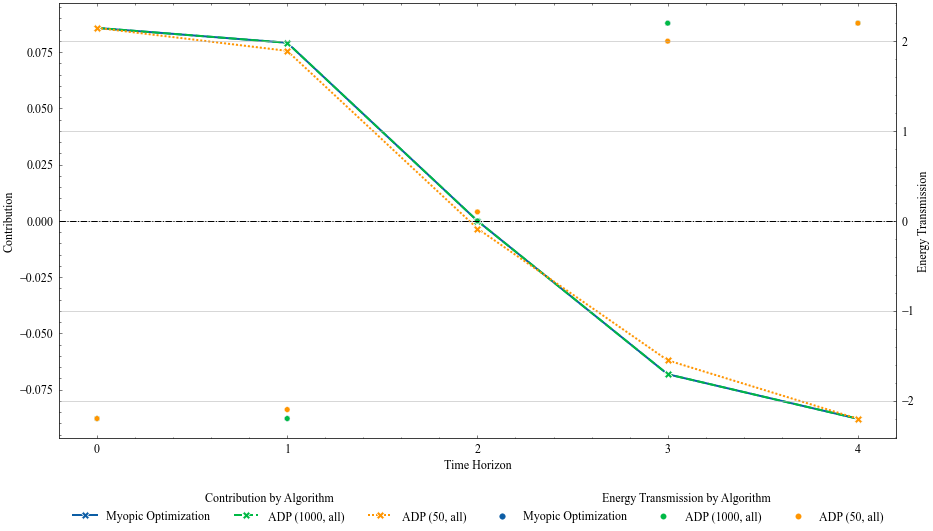

In [65]:
adp1000 = pd.read_pickle("/usr/app/output/scen/[%s-%s]-adp(1000,all)_scenarios.pkl" % (param["T"], param["trip_max"]))
adp50 = pd.read_pickle("/usr/app/output/scen/[%s-%s]-adp(50,all)_scenarios.pkl" % (param["T"], param["trip_max"]))

adp1000["Algorithm"] = "ADP(1000,all)"
adp50["Algorithm"] = "ADP(50,all)"



# 5.[~VI] Decision with price and trip demand
plt_decisions = pd.concat([
    pd.read_pickle("/usr/app/output/scen/[%s-%s]-mo_scenarios.pkl" % (param["T"], param["trip_max"])),
    adp1000,
    adp50
]).astype({"t": int, "P_B": float, "P_S": float, "xG2V": float, "xV2G": float})


legend = ['Myopic Optimization', 'ADP (1000, all)','ADP (50, all)']

plt_decisions = plt_decisions.loc[plt_decisions.Scenario == 1]
plt_decisions["xV2G"] = plt_decisions["xV2G"]*-1
plt_decisions["Energy Transmision"] = plt_decisions["xG2V"]+plt_decisions["xV2G"]
plt_decisions = pd.melt(plt_decisions, id_vars=[ x for x in plt_decisions.columns if x not in ["P_B", "P_S"]],value_vars=["P_B", "P_S"], var_name = "Price Type", value_name = "Price")
plt_decisions["Price Type"].replace({"P_B": "Price Buy", "P_S": "Price Sell"}, inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_decisions, x="t", y="Price", hue="Price Type",style="Price Type", markers=["v","^"],  legend = True,
                   palette = list(plt.rcParams['axes.prop_cycle'].by_key()['color'][3:5]), linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon" , "Price", None, None, None, "Price Type", None, "center right", bbox=(0.4, -0.1))
ax2 = g.twinx()
g = sns.scatterplot(ax=ax2, data=plt_decisions, x="t", y="Energy Transmision", hue="Algorithm",   legend = True)
plttr.formatPlot(g, "Time Horizon" , "Energy Transmission","Energy Transmission Decisions for Scenario Prices",np.arange(0, plt_decisions["t"].max()+1, 1), None, "Energy Transmission by Algorithm", legend, "center right", bbox=(0.97, -0.1))
ax2.grid()
g.axhline(0, ls='-.', color = "black")


plts += [("decision_comp_price", plt.gcf())]

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.scatterplot(ax=ax, data=plt_decisions, x="t", y="D", style="smpl", hue="smpl" ,markers=["D"],  legend = False,
                   palette = list(plt.rcParams['axes.prop_cycle'].by_key()['color'][3:4]))
plttr.formatPlot(g, "Time Horizon" , "Trip Demand",None)
ax2 = g.twinx()
g = sns.scatterplot(ax=ax2, data=plt_decisions, x="t", y="Energy Transmision", hue="Algorithm",   legend = True)
plttr.formatPlot(g, "Time Horizon" , "Energy Transmission","Energy Transmission Decisions for Trip Demand",np.arange(0, plt_decisions["t"].max()+1, 1), None, "Algorithm", legend, "upper center")
ax2.grid()
g.axhline(0, ls='-.', color = "black")


plts += [("decision_comp_demand", plt.gcf())]

fig, ax = plt.subplots(figsize=(15, 8))
g1 = sns.lineplot(ax=ax, data=plt_decisions, x="t", y="Contribution", style="Algorithm", hue="Algorithm" ,markers=["X", "X", "X"],  legend = True,
                   palette = list(plt.rcParams['axes.prop_cycle'].by_key()['color'][0:3]), linewidth=lw, markersize=ms)
plttr.formatPlot(g, "Time Horizon" , "Contribution",None,np.arange(0, plt_decisions["t"].max()+1, 1), None, "Contribution by Algorithm", legend, "upper right", bbox=(0.5, -0.1))
ax2 = g1.twinx()
g = sns.scatterplot(ax=ax2, data=plt_decisions, x="t", y="Energy Transmision", hue="Algorithm",   legend = True,
                   palette = list(plt.rcParams['axes.prop_cycle'].by_key()['color'][0:3]))
plttr.formatPlot(g, "Time Horizon" , "Energy Transmission","Energy Transmission Decisions and Resulting Contribution",np.arange(0, plt_decisions["t"].max()+1, 1), None, "Energy Transmission by Algorithm", legend, "upper center", bbox=(0.75, -0.1))
ax2.grid()
g.axhline(0, ls='-.', color = "black")
align.yaxes(g1, 0, g, 0, 0.5)


plts += [("decision_comp_value", plt.gcf())]

In [77]:
plts

[('decision_comp_price', <Figure size 1080x576 with 2 Axes>),
 ('decision_comp_demand', <Figure size 1080x576 with 2 Axes>),
 ('decision_comp_value', <Figure size 1080x576 with 2 Axes>),
 ('mo_rt', <Figure size 1080x576 with 1 Axes>),
 ('adp_rt', <Figure size 1080x576 with 1 Axes>),
 ('vi_state_space_25', <Figure size 1080x576 with 1 Axes>),
 ('vi_state_space_50', <Figure size 1080x576 with 1 Axes>),
 ('vi_decision_space_25', <Figure size 1080x576 with 1 Axes>),
 ('vi_decision_space_50', <Figure size 1080x576 with 1 Axes>),
 ('vi_transition_space_25', <Figure size 1080x576 with 1 Axes>),
 ('vi_transition_space_50', <Figure size 1080x576 with 1 Axes>),
 ('vi_rt_25', <Figure size 1080x576 with 1 Axes>),
 ('vi_splitrt_25', <Figure size 1080x576 with 1 Axes>),
 ('vi_rt_50', <Figure size 1080x576 with 1 Axes>),
 ('vi_splitrt_50', <Figure size 1080x576 with 1 Axes>)]

In [78]:
# Export plots
print(plts)
plttr.save(plts)

[('decision_comp_price', <Figure size 1080x576 with 2 Axes>), ('decision_comp_demand', <Figure size 1080x576 with 2 Axes>), ('decision_comp_value', <Figure size 1080x576 with 2 Axes>), ('mo_rt', <Figure size 1080x576 with 1 Axes>), ('adp_rt', <Figure size 1080x576 with 1 Axes>), ('vi_state_space_25', <Figure size 1080x576 with 1 Axes>), ('vi_state_space_50', <Figure size 1080x576 with 1 Axes>), ('vi_decision_space_25', <Figure size 1080x576 with 1 Axes>), ('vi_decision_space_50', <Figure size 1080x576 with 1 Axes>), ('vi_transition_space_25', <Figure size 1080x576 with 1 Axes>), ('vi_transition_space_50', <Figure size 1080x576 with 1 Axes>), ('vi_rt_25', <Figure size 1080x576 with 1 Axes>), ('vi_splitrt_25', <Figure size 1080x576 with 1 Axes>), ('vi_rt_50', <Figure size 1080x576 with 1 Axes>), ('vi_splitrt_50', <Figure size 1080x576 with 1 Axes>)]


In [ ]:
## WONT DO
# [VI] 1. Space comparison in dependence of parameters
# Combine spaces
#space = pd.concat([stateSpace, decisionSpace, totalSpace], axis = 1)
#space.reset_index(level=0, inplace=True)
#space.columns = ["Parameter","State", "Decision", "Total"]
#space = pd.melt(space, id_vars=["Parameter"], value_vars=["State", "Decision", "Total"]).astype({"value": int})

#allVar = [("rt", runtime), ("splitrt", splitRuntime), ("space", space), ("sspace", stateSpace), ("dspec", decisionSpace), ("tspace", totalSpace)]
#plts += [("space_comparison", p.plot_space(allVar[2]))]

In [ ]:
# 3. [ALL] Runtime comparison WONTDOW


####### IMPORTANT - SET PARAM T AND TRIP_MAX ACCORDINGLY
param["trip_max"] = 20
param["T"] = 4

plt_rt = pd.DataFrame()

for algo in runs:
    tmp = pd.read_pickle("/usr/app/output/xlsx/%s/rt.pkl" % algo[1]).astype({"T":int})
    tmp["algo"] = algo[0]
    plt_rt = plt_rt.append(tmp)

plt_rt_t = plt_rt[(plt_rt.trip_max == param["trip_max"])].copy()
plt_rt_trip_max = plt_rt[(plt_rt["T"] == param["T"])].copy()

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_rt_t, x="T", y="time", hue="algo", style="algo", markers=True, legend = True)
plttr.formatPlot(g, "Time Horizon" , "Runtime (s)","Runtime of Algoritms for Different Time Horizons",None, None,"Algorithm")
plts += [("rt_all_t_20_trip_max", plt.gcf())]

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_rt_trip_max, x="trip_max", y="time", hue="algo", style="algo", markers=True, legend = True)
plttr.formatPlot(g, "Max. Trip Length" , "Runtime (s)","Runtime of Algoritms for Different Max. Trip Lengths", None,None, "Algorithm")
plts += [("rt_all_trip_max_5_t", plt.gcf())]

In [ ]:
# 4.[~VI] Value according to algorithm and scenario WONT DO
plt_value = pd.read_pickle("/usr/app/output/scen/[%s-%s]-value_comp.pkl" % (param["T"], param["trip_max"]))

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_value, x="Scenario", y="Value", hue="Algorithm",style="Algorithm", markers=True,  legend = False)
plttr.formatPlot(g, "Scenario" , "Value","Value of Decisions for Different Scenarios (T=%d - Max. Trip Length = %s)" % (param["T"], param["trip_max"]),np.arange(0, 3, 1), None, "Algorithm", ['Myopic Optimization', 'Approx. Dynamic Programming'], "upper left")
g.set_xticklabels(["Most Unlikely", "Most Likely", "1000 Samples"])
g.grid()
plts += [("value_comp", plt.gcf())]